In [105]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
from mplsoccer.pitch import Pitch
import json
import pandas as pd
import re
from math import isnan
from datetime import datetime, timedelta
%run smoothing.ipynb


0.007071067811656502
0.00707106781165085
0.0070710678116621545
0.0070710678116621545
(-1, -1)


In [106]:
import csv

def read_csv_partially(file_path, start_line, end_line):
    data = []  # List to store extracted CSV rows

    with open(file_path, 'r', newline='') as file:
        reader = csv.reader(file)
        for line_num, row in enumerate(reader):
            if line_num >= start_line and line_num <= end_line:
                # Append the row to data
                data.append(row)
            elif line_num > end_line:
                break  # Stop reading once end_line is reached

    return data

In [107]:
file_path_skillcorner = '../data/matches/Feb/1384039_tracking.csv'
lineup_path = '../data/matches/Feb/1384039_lineup.csv'
partialframes = read_csv_partially(file_path_skillcorner, 0, 1500000)

lineup = read_csv_partially(lineup_path, 0, 33)
# targetIDSkillcorner = 7679
targetIDSkillcorner = 10218
targetPositionsSkillcorner = []

playerIDs = set()
teamName = "FC Basel"

for player in list(filter(lambda player: player[1] == teamName, lineup[1:])):
    playerIDs.add(str(player[2]))

targetTrajs = {}
playerSmoothDataFrames = pd.DataFrame()
for ID in playerIDs:
    targetTrajs[ID] = []
    playerSmoothDataFrames = pd.DataFrame()

for index, playerFrame in enumerate(partialframes):
    # print(playerFrame)

    if(playerFrame[4] not in playerIDs or playerFrame[8] == 'True'):
        continue

    # defining datapoints d_i = [x_Coordinate, y_Coordinate, speed, time]
    if targetTrajs[playerFrame[4]] == [] or int(targetTrajs[playerFrame[4]][-1][-1][-1]) != (int(playerFrame[2]) - 1):
        targetTrajs[playerFrame[4]].append([])
        
    targetTrajs[playerFrame[4]][-1].append([float(playerFrame[5]), float(playerFrame[6]), 0, datetime.fromtimestamp(int(playerFrame[3])/1000.0), int(playerFrame[2])])


KeyError: '258924'

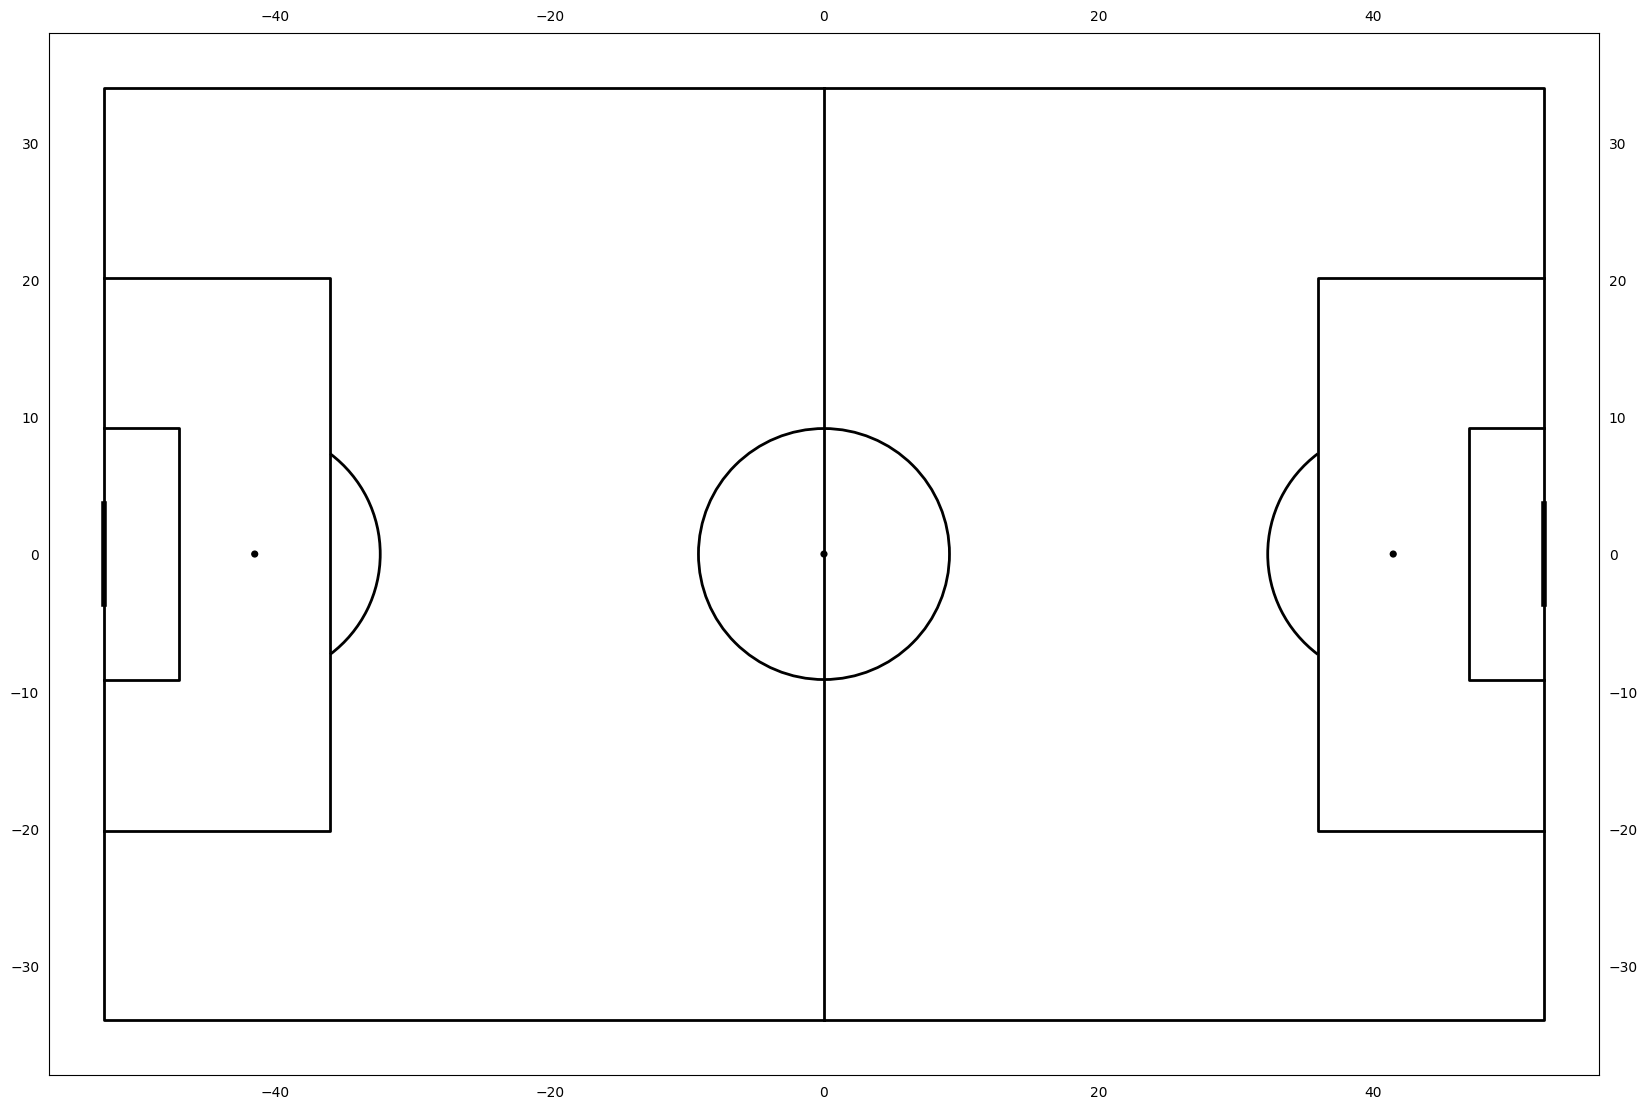

In [108]:
#write a function that plots the movement (positions in each frame) of player with id 258924 between frame 34591 and 34764 on the pitch
# start_frame=34591
# end_frame=34764
# def plot_movement(playerID, start_frame=34591, end_frame=34764):

#     pitch = Pitch(pitch_type='skillcorner', axis=True, label=True,
#                   pitch_length=105, pitch_width=68,
#                   pitch_color='white', line_color='black',)

#     fig, ax = pitch.draw(figsize=(20, 16), constrained_layout=True, tight_layout=False)
#     for frame in targetTrajs[playerID]:
#         for i in range(1, len(frame)):
#             if frame[i][-1] >= start_frame and frame[i][-1] <= end_frame:
#                 x = frame[i][0]
#                 y = frame[i][1]
#                 if frame[i][-1] == end_frame:
#                     giani = frame
#                 if isnan(x) or isnan(y):
#                     continue
#                 ax.plot(x, y, 'ro', markersize=20, color='blue')
#                 if i > 1:
#                     x_prev = frame[i-1][0]
#                     y_prev = frame[i-1][1]
#                     if isnan(x_prev) or isnan(y_prev):
#                         continue
#                     ax.plot([x_prev, x], [y_prev, y], 'r-')
#                     ax.arrow(x_prev, y_prev, x - x_prev, y - y_prev, color='r')
                    
#     #zoom in on the player's movement
#     #change code above to decrease the size of the points on the plot
#     ax.set_xlim([-2.5, -2.4])
#     ax.set_ylim([10.15, 10.2])
#     plt.show()
#     return giani

# giani = plot_movement('258924')
# print(len(giani))



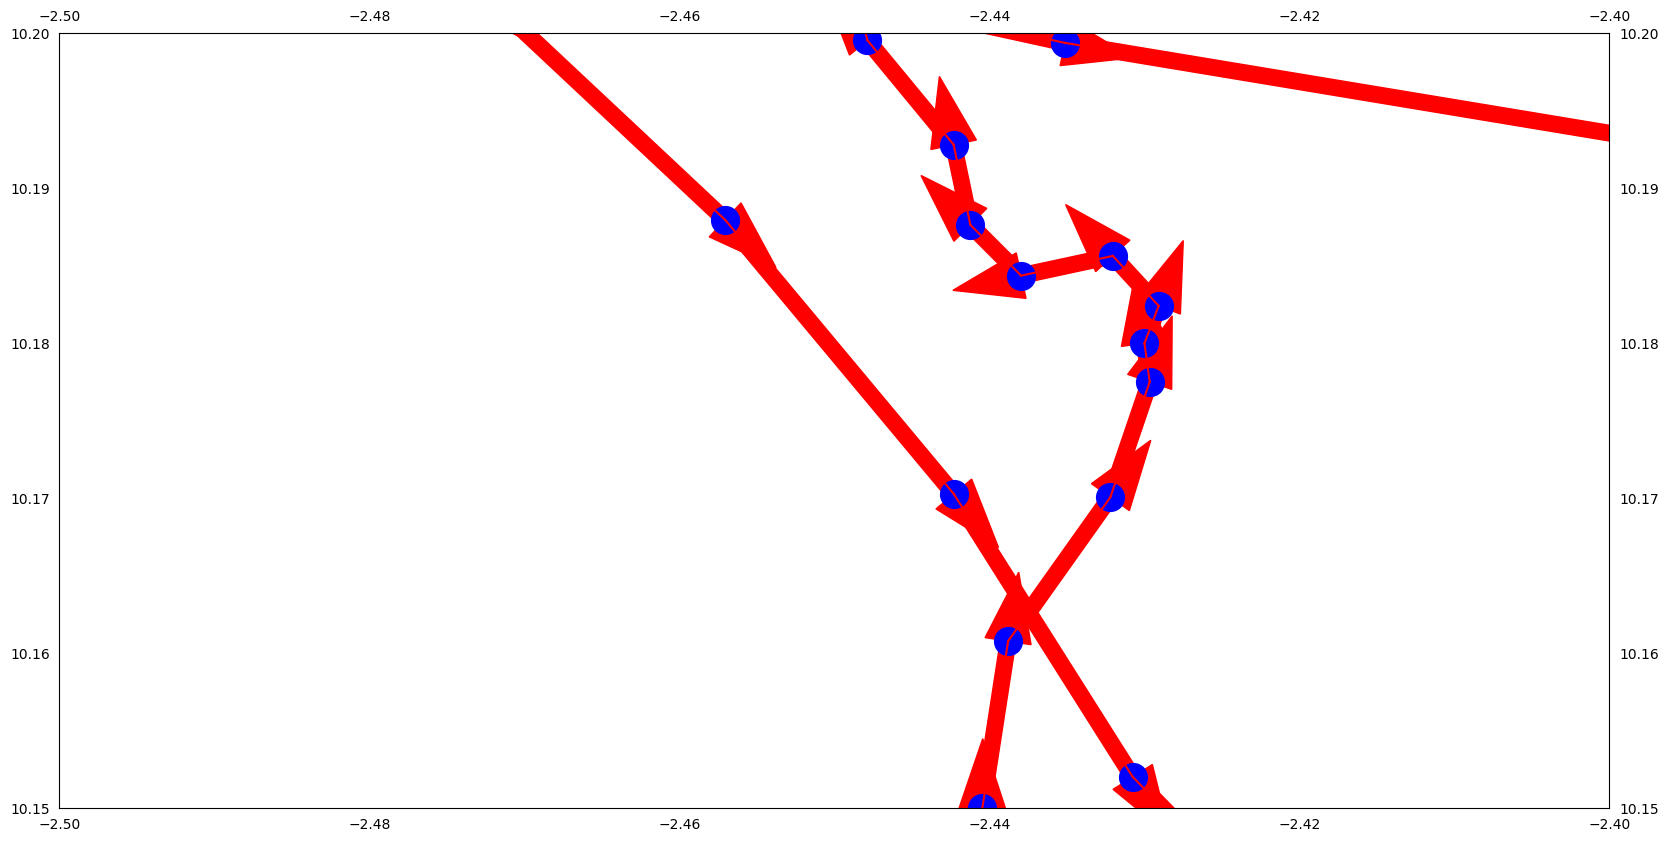

In [ ]:
# pitch = Pitch(pitch_type='skillcorner', axis=True, label=True,
#                   pitch_length=105, pitch_width=68,
#                   pitch_color='white', line_color='black',)

# fig, ax = pitch.draw(figsize=(20, 16), constrained_layout=True, tight_layout=False)
# frame = performSmoothing(giani, 1)
# for i in range(1, len(frame)):
#     x = frame[i][0]
#     y = frame[i][1]
#     if isnan(x) or isnan(y):
#         continue
#     ax.plot(x, y, 'ro', markersize=20, color='blue')
#     if i > 1:
#         x_prev = frame[i-1][0]
#         y_prev = frame[i-1][1]
#         if isnan(x_prev) or isnan(y_prev):
#             continue
#         ax.plot([x_prev, x], [y_prev, y], 'r-')
#         ax.arrow(x_prev, y_prev, x - x_prev, y - y_prev, color='r')
# ax.set_xlim([-2.5, -2.4])
# ax.set_ylim([10.15, 10.2])
# plt.show()

In [ ]:
# add for loop that starts here and smootens every trajectory in the traj list
playerSmoothDataFrames = pd.DataFrame()

for player, trajs in targetTrajs.items():
    if player == []:
        continue

    for traj in trajs:
        if(len(traj) < 2):
            continue

        new_traj = performSmoothing(datapoints=traj, iterations=10)
        new_traj = pd.DataFrame(new_traj)
        new_traj[5] = player
        traj = pd.DataFrame(traj)
        for idx, row in traj.iterrows():
            if(isnan(row[4])):
                print('nan')

        new_traj[4] = traj[4]

        playerSmoothDataFrames = pd.concat([playerSmoothDataFrames, new_traj], axis=0, ignore_index=True)

originalDF = pd.DataFrame(partialframes[1:])

playerSmoothDataFrames[4] = playerSmoothDataFrames[4].astype(int)

playerSmoothDataFrames.columns = ['x', 'y', 'speed', 'time', 'frame_id', 'object_id']
originalDF.columns = ['match_id', 'half', 'frame_id', 'timestamp', 'object_id', 'x', 'y', 'z', 'extrapolated']

originalDF['frame_id'] = originalDF['frame_id'].astype(int)
newDF = originalDF.merge(playerSmoothDataFrames, how='left', on=['object_id', 'frame_id'])


In [ ]:
newDF

,match_id,half,frame_id,timestamp,object_id,x_x,y_x,z,extrapolated,x_y,y_y,speed,time
0,1296476,1,100,0,-1,0.46,0.3,0.17,True,NaN,NaN,NaN,NaT
1,1296476,1,100,0,34469,-39.43,0.59,0.0,True,NaN,NaN,NaN,NaT
2,1296476,1,100,0,22148,-20.81,-0.41,0.0,True,NaN,NaN,NaN,NaT
3,1296476,1,100,0,59888,-18.07,-11.77,0.0,True,NaN,NaN,NaN,NaT
4,1296476,1,100,0,33868,-18.61,12.24,0.0,False,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995159,1296476,2,58014,3009400,68780,-25.91,-0.16,0.0,True,NaN,NaN,NaN,NaT
995160,1296476,2,58014,3009400,16979,-30.17,28.1,0.0,False,NaN,NaN,NaN,NaT
995161,1296476,2,58014,3009400,8939,-26.85,-5.45,0.0,True,NaN,NaN,NaN,NaT
995162,1296476,2,58014,3009400,688364,-31.14,-5.51,0.0,True,NaN,NaN,NaN,NaT


In [ ]:
newDF['x_x'] = newDF['x_y'].fillna(newDF['x_x'])
newDF['y_x'] = newDF['y_y'].fillna(newDF['y_x'])

newDF.drop(columns=['x_y', 'y_y', 'speed', 'time'], inplace=True)

newDF


,match_id,half,frame_id,timestamp,object_id,x_x,y_x,z,extrapolated
0,1296476,1,100,0,-1,0.46,0.3,0.17,True
1,1296476,1,100,0,34469,-39.43,0.59,0.0,True
2,1296476,1,100,0,22148,-20.81,-0.41,0.0,True
3,1296476,1,100,0,59888,-18.07,-11.77,0.0,True
4,1296476,1,100,0,33868,-18.61,12.24,0.0,False
...,...,...,...,...,...,...,...,...,...
995159,1296476,2,58014,3009400,68780,-25.91,-0.16,0.0,True
995160,1296476,2,58014,3009400,16979,-30.17,28.1,0.0,False
995161,1296476,2,58014,3009400,8939,-26.85,-5.45,0.0,True
995162,1296476,2,58014,3009400,688364,-31.14,-5.51,0.0,True
